In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd

## To print everything in a cell, not just the last print statement ##
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv('application_train.csv', header=0)

In [3]:
def classCountsInAnInterval(sub_df, interval):
    """ Returns the total number of instances of  paid/unpaid loans in a given interval """
    """ Input: Dataframe with class counts of the interval passed """
    class0, class1 = 0, 0
    # This check to handle cases where few intervals have only either paid/un-paid loans.
    if np.isscalar(sub_df[sub_df["loan_paid_status"] == 1]):
        class0 = class0 + sub_df[sub_df["loan_paid_status"] == 0]
        class1 = class1 + sub_df[sub_df["loan_paid_status"] == 1]
    else:
        class0 = class0 + int(sub_df[sub_df["loan_paid_status"] == 0]['count'])
        class1 = class1 + int(sub_df[sub_df["loan_paid_status"] == 1]['count'])
    return (class0+class1, class1, interval)

In [4]:
def getIntervalBasedCounts(df, category, no_of_bins=50):
    """ Input: A continous numerical category """
    """ Create bins from the category data points and count total loans, unpaid loans for each bin """
    
    # Create bins #
    continous_numerical_category = category
    binned_columns_name = continous_numerical_category + '_BINNED'
    credit_and_loan_df = pd.DataFrame(data={'loan_paid_status': df['TARGET'], 
                                     continous_numerical_category: df[continous_numerical_category] })
    credit_and_loan_df[binned_columns_name] = pd.cut(credit_and_loan_df[continous_numerical_category], 
                                                     bins = np.linspace(
                                                         min(credit_and_loan_df[continous_numerical_category]), 
                                                         max(credit_and_loan_df[continous_numerical_category]), 
                                                         num = no_of_bins),
                                                     retbins=False)
    
    # Groupby "bin + loan_paid_status" and agg the size of each group.
    # This calculates the paid and unpaid loans counts in each bin.
    credit_and_loan_df = credit_and_loan_df.groupby([binned_columns_name, 'loan_paid_status']).size().to_frame()
    credit_and_loan_df.reset_index(inplace=True)
    credit_and_loan_df.set_index(binned_columns_name, inplace=True)
    
    # Binned column is of  type "Categorical Index" which is not useful in that format. #
    # Converting the bins to string format so that we can plot better based on bin. #
    integer_intervals = list(map(lambda interval: (interval.left,interval.right), credit_and_loan_df.index))
    credit_and_loan_df['integer_intervals'] = list(map(lambda interval: 
                                                       str(int(interval[0])) + '-' + str(int(interval[1])), 
                                                       integer_intervals))
    credit_and_loan_df.reset_index(inplace=True)
    # Drop the bins column of type "Categorical Index"
    credit_and_loan_df = credit_and_loan_df.drop([binned_columns_name], axis=1)
    credit_and_loan_df.set_index('integer_intervals', inplace=True)
    credit_and_loan_df = credit_and_loan_df.rename(columns={0: "count"})
    
    # The dataframe looks like the following
    # bin1 - loan_paid_count
    # bin1 - loan_not_paid_count
    # bin2 - loan_paid_count
    # bin2 - loan_not_paid_count ...
    
    # Calculate the total loans and percentage of unpaid loans in each bin.
    totalCountAndUnpaidCountPerInterval = pd.DataFrame(list(map(lambda interval: 
                                                                classCountsInAnInterval(
                                                                    credit_and_loan_df.loc[interval], interval), 
                                                                list(set(credit_and_loan_df.index)))), 
                                                       columns=['Total Loans', 'Unpaid Loans', 
                                                                continous_numerical_category])
    totalCountAndUnpaidCountPerInterval['percentage_unpaid_loans'] = (totalCountAndUnpaidCountPerInterval['Unpaid Loans'] 
                                                                      / totalCountAndUnpaidCountPerInterval['Total Loans']) * 100
    return totalCountAndUnpaidCountPerInterval

In [5]:
def plotTotalAndUnpaidLoansPerBin(df, featureColumn, totalLoansColumn = "Total Loans", 
                                  unpaidLoansColumn = "Unpaid Loans", top_n_intervals=20, 
                                  figsize=(30, 30), transpose=False):
    """ Plots bins versus total number of loans and unpaid loans """
    total_axes_data = [featureColumn, totalLoansColumn]
    unpaid_axes_data = [featureColumn, unpaidLoansColumn]
    if transpose:
        total_axes_data[0], total_axes_data[1] = total_axes_data[1], total_axes_data[0]
        unpaid_axes_data[0], unpaid_axes_data[1] = unpaid_axes_data[1], unpaid_axes_data[0]
    sns.set(style="whitegrid")
    df = df.sort_values(totalLoansColumn, ascending=False).head(top_n_intervals)
    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Plot the total loans
    sns.set_color_codes("pastel")
    sns.barplot(x=total_axes_data[0], y=total_axes_data[1], data=df, label="Total", color="b")

    # Plot the loans which were unpaid
    sns.set_color_codes("muted")

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('xlabel', fontsize=20)
    plt.ylabel('ylabel', fontsize=20)

    sns.barplot(x=unpaid_axes_data[0], y=unpaid_axes_data[1], data=df, label="Unpaid Loans", color="b")

    # Add a legend and informative axis label
    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set(ylabel=featureColumn, xlabel="Number of loans")
    sns.despine(left=True, bottom=True)
    return df

In [6]:
def plotPercentageUnpaidLoansPerBin(df, feature, top_n_intervals=20, figsize=(30, 30), transpose=False):
    """ Plots bins versus percentage of unpaid loans in that bin """
    font = {
        'weight' : 'bold',
        'size'   : 40
    }
    axes_data = [feature, 'percentage_unpaid_loans']
    if transpose:
        axes_data[0], axes_data[1] = axes_data[1], axes_data[0]
    matplotlib.rc('font', **font)
    f, axes = plt.subplots(1, 1, figsize=figsize)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('xlabel', fontsize=10)
    plt.ylabel('ylabel', fontsize=10)
    df = df.sort_values('percentage_unpaid_loans',  ascending=False).head(top_n_intervals)
    ax = sns.barplot(x=axes_data[0], y=axes_data[1], data=df, ax=axes)
    return df

In [7]:
def processCategoricalFeature(category):
    df_category = pd.DataFrame(df, columns=[category, 'TARGET'])
    df_category = df_category.groupby([category, 'TARGET']).size().to_frame()
    df_category.reset_index(inplace=True)
    df_category.set_index(category, inplace=True)
    df_category.rename(columns={0: "count"}, inplace=True)
    df_category.rename(columns={'TARGET': "loan_paid_status"}, inplace=True)
    df_category = pd.DataFrame(list(map(lambda interval: classCountsInAnInterval(df_category.loc[interval], interval), 
                                 list(set(df_category.index)))), 
                        columns=['Total Loans', 'Unpaid Loans', feature_name])
    df_category['percentage_unpaid_loans'] = (df_category['Unpaid Loans'] / df_category['Total Loans']) * 100
    return df_category

In [17]:
feature_name = "ORGANIZATION_TYPE"

In [18]:
feature_summary = processCategoricalFeature(feature_name)

list(feature_summary[feature_name])

# threshold = 75
# mean_number_loans = feature_summary["Total Loans"].mean()

# min_threshold = mean_number_loans - ((threshold/100) * mean_number_loans)
# print("Mean of \"number of loans\" in each bin", mean_number_loans)

# feature_summary = feature_summary[(feature_summary["Total Loans"] >= min_threshold)]

feature_summary

['Trade: type 7',
 'Security Ministries',
 'University',
 'Housing',
 'Mobile',
 'Bank',
 'Transport: type 3',
 'Business Entity Type 3',
 'XNA',
 'Advertising',
 'Construction',
 'Industry: type 2',
 'Industry: type 10',
 'Trade: type 6',
 'Business Entity Type 2',
 'Other',
 'Electricity',
 'Trade: type 5',
 'Telecom',
 'Industry: type 6',
 'School',
 'Restaurant',
 'Legal Services',
 'Military',
 'Trade: type 2',
 'Government',
 'Insurance',
 'Security',
 'Transport: type 2',
 'Hotel',
 'Trade: type 4',
 'Culture',
 'Cleaning',
 'Transport: type 4',
 'Industry: type 4',
 'Postal',
 'Self-employed',
 'Services',
 'Industry: type 11',
 'Trade: type 3',
 'Industry: type 1',
 'Realtor',
 'Emergency',
 'Industry: type 8',
 'Medicine',
 'Business Entity Type 1',
 'Industry: type 3',
 'Industry: type 13',
 'Religion',
 'Industry: type 7',
 'Trade: type 1',
 'Industry: type 12',
 'Transport: type 1',
 'Agriculture',
 'Industry: type 9',
 'Police',
 'Industry: type 5',
 'Kindergarten']

,Total Loans,Unpaid Loans,ORGANIZATION_TYPE,percentage_unpaid_loans
0,7831,740,Trade: type 7,9.449623
1,1974,96,Security Ministries,4.863222
2,1327,65,University,4.898267
3,2958,235,Housing,7.944557
4,317,29,Mobile,9.148265
5,2507,130,Bank,5.185481
6,1187,187,Transport: type 3,15.754002
7,67992,6323,Business Entity Type 3,9.299623
8,55374,2990,XNA,5.399646
9,429,35,Advertising,8.158508


,Total Loans,Unpaid Loans,ORGANIZATION_TYPE,percentage_unpaid_loans
7,67992,6323,Business Entity Type 3,9.299623
8,55374,2990,XNA,5.399646
36,38412,3908,Self-employed,10.173904
15,16683,1275,Other,7.642510
44,11193,737,Medicine,6.584472
14,10553,900,Business Entity Type 2,8.528381
25,10404,726,Government,6.978085
20,8893,526,School,5.914764
0,7831,740,Trade: type 7,9.449623
57,6880,484,Kindergarten,7.034884


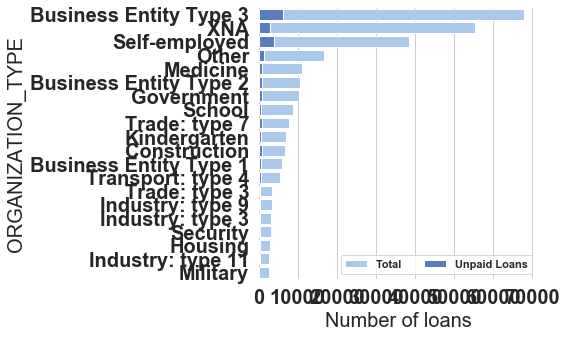

In [22]:
plotTotalAndUnpaidLoansPerBin(feature_summary, feature_name, figsize=(5,5), transpose=True, top_n_intervals=20)

,Total Loans,Unpaid Loans,ORGANIZATION_TYPE,percentage_unpaid_loans
6,1187,187,Transport: type 3,15.754002
47,67,9,Industry: type 13,13.432836
43,24,3,Industry: type 8,12.500000
21,1811,212,Restaurant,11.706240
10,6721,785,Construction,11.679810
32,260,29,Cleaning,11.153846
40,1039,115,Industry: type 1,11.068335
46,3278,348,Industry: type 3,10.616229
41,396,42,Realtor,10.606061
53,2454,257,Agriculture,10.472698


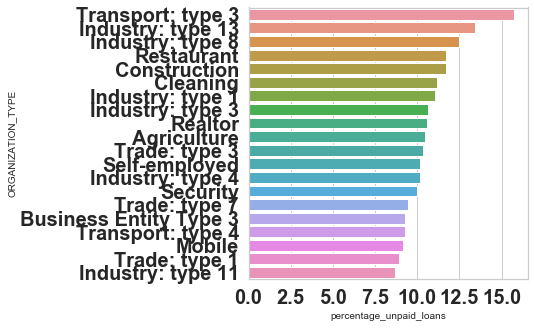

In [20]:
plotPercentageUnpaidLoansPerBin(feature_summary, feature_name, figsize=(5,5), transpose=True)

In [2]:
!curl -o covid.csv https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_confirmed_usafacts.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  854k  100  854k    0     0  1894k      0 --:--:-- --:--:-- --:--:-- 1894k
